# YOU NEEED: 
    - 150 GB to run
    - Lots of DASK

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import glob
import scipy
import copy
import math
import time

#plotting with Cartopy. 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import cm
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import ticker


# import scipy
from datetime import datetime
import os
# import utils
import importlib


# import statsmodels.api as sm
# from windspharm.xarray import VectorWind
# from windspharm.standard import VectorWind
# from windspharm.examples import example_data_path
# from windspharm.tools import prep_data, recover_data, order_latdim
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from shapely.geometry.polygon import LinearRing
from dask.diagnostics import ProgressBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import math
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import geocat.comp as gcomp
import shutil
import metpy.calc as mpcalc


## Get ADF to do this for you

In [4]:
if 'client' in locals():
    client.shutdown()
    print('...shutdown client...')
else:
    print('client does not exist yet')

client does not exist yet


In [5]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster(project='P54048000',walltime='06:00:00')
cluster.scale(40)
client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/3rd_EOFs/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/3rd_EOFs/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.30:37312,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/3rd_EOFs/proxy/8787/status,Total threads: 0
Started: 2 minutes ago,Total memory: 0 B


## Free Running:

### helpful functions

In [6]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


def wgt_rmse(fld1, fld2, wgt):
    """Calculated the area-weighted RMSE.
    Inputs are 2-d spatial fields, fld1 and fld2 with the same shape.
    They can be xarray DataArray or numpy arrays.
    Input wgt is the weight vector, expected to be 1-d, matching length of one dimension of the data.
    Returns a single float value.
    """
    assert len(fld1.shape) == 2,     "Input fields must have exactly two dimensions."
    assert fld1.shape == fld2.shape, "Input fields must have the same array shape."
    # in case these fields are in dask arrays, compute them now.
    if hasattr(fld1, "compute"):
        fld1 = fld1.compute()
    if hasattr(fld2, "compute"):
        fld2 = fld2.compute()
    if isinstance(fld1, xr.DataArray) and isinstance(fld2, xr.DataArray):
        return (np.sqrt(((fld1 - fld2)**2).weighted(wgt).mean())).values.item()
    else:
        check = [len(wgt) == s for s in fld1.shape]
        if ~np.any(check):
            raise IOError(f"Sorry, weight array has shape {wgt.shape} which is not compatible with data of shape {fld1.shape}")
        check = [len(wgt) != s for s in fld1.shape]
        dimsize = fld1.shape[np.argwhere(check).item()]  # want to get the dimension length for the dim that does not match the size of wgt
        warray = np.tile(wgt, (dimsize, 1)).transpose()   # May need more logic to ensure shape is correct.
        warray = warray / np.sum(warray) # normalize
        wmse = np.nansum(warray * (fld1 - fld2)**2)
        return np.sqrt( wmse ).item()

#######


In [7]:
# ls /glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_05_1982/atm/hist/*h0*

In [8]:
# ls /glade/work/wchapman/cesm/stochai/f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_05_1982

In [9]:
# ls /glade/scratch/wchapman/ADF/cvdp/

In [10]:
# ls /glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_stochai_DA_UV*

In [11]:
# ls /glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_00_1982/atm/hist/*h1*

In [12]:
# ls /glade/campaign/cisl/aiml/wchapman/CAM_runs/Nudge_DA/

In [13]:
# DS = xr.open_dataset('/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_00_1982/atm/hist/f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_00_1982.cam.h1.1982-03-14-00000.nc')
# DS['Nudge_U'].sel(lev=200,method='nearest').isel(time=0).plot()

# Experiments: 
    -Free Running: 
        -/glade/campaign/cisl/aiml/wchapman/CAM_runs/f.e21.DAcompset.f09_d025_free_MJO_1982
    -Nudge No Stochai: 
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_00_1982
    -Nudge Stochai
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_stochai_UV_05_1982_MJO_v3
    -DA No Stochai: 
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_00_1982
    -DA Stochai
        -/glade/scratch/wchapman/archive/f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_05_1982/

## INCS in

In [34]:
%%time 
modvers = 'f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_00_1982'
fil_out = '/glade/work/wchapman/CESM_h0_summaryfiles/' + modvers +'_h1summary.nc'
path_tofiles='/glade/scratch/wchapman/archive/' + modvers + '/atm/hist/*h1*.nc'
remake_files = False
dovars = ['Nudge_U','Nudge_V','Stochai_U','Stochai_V','U','V']

if (os.path.exists(fil_out)) & (remake_files):
    os.remove(fil_out)

if not os.path.exists(fil_out):
    fns = sorted(glob.glob(path_tofiles))
    program_starts = time.time()

    for ee,group in enumerate(chunker(fns,100)):
        print('doing group: ',ee,' of ',len(fns)/100)
        # print(group)
        DS = xr.open_mfdataset(group,parallel=True)
        print('..opened..')
        if ee == 0:
            # bbedo = DS[dovars].load()
            bbedo = DS[dovars]
        else: 
            # temp_bbedo = DS[dovars].load()
            temp_bbedo = DS[dovars]
            print('concat')
            bbedo = xr.concat([bbedo,temp_bbedo],dim='time')

        now = time.time()
        print("It has been {0} seconds since the loop started".format(now - program_starts))

    # bbedo['time']=pd.date_range(start=fns[0].split('.h0.')[-1].split('.nc')[0],end=fns[-1].split('.h0.')[-1].split('.nc')[0],freq='MS')
    # bbedo.to_netcdf(fil_out)
    
else:
    print('file existed... opening')
    bbedo = xr.open_dataset(fil_out)

doing group:  0  of  35.31
..opened..
It has been 5.144088268280029 seconds since the loop started
doing group:  1  of  35.31
..opened..
concat
It has been 9.060420751571655 seconds since the loop started
doing group:  2  of  35.31
..opened..
concat
It has been 16.828181266784668 seconds since the loop started
doing group:  3  of  35.31
..opened..
concat
It has been 24.232940196990967 seconds since the loop started
doing group:  4  of  35.31
..opened..
concat
It has been 30.382892608642578 seconds since the loop started
doing group:  5  of  35.31
..opened..
concat
It has been 37.323890686035156 seconds since the loop started
doing group:  6  of  35.31
..opened..
concat
It has been 43.986032009124756 seconds since the loop started
doing group:  7  of  35.31
..opened..
concat
It has been 51.36367917060852 seconds since the loop started
doing group:  8  of  35.31
..opened..
concat
It has been 58.86913347244263 seconds since the loop started
doing group:  9  of  35.31
..opened..
concat
It 

## Get Stochastics from h1 files: 

In [35]:
%%time 
modvers = 'f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_00_1982'
fil_out = '/glade/work/wchapman/CESM_h0_summaryfiles/' + modvers +'_h1summary.nc'
path_tofiles='/glade/scratch/wchapman/archive/' + modvers + '/atm/hist/*h1*.nc'
remake_files = False
dovars = ['Nudge_U','Nudge_V','Stochai_U','Stochai_V','U','V']

if (os.path.exists(fil_out)) & (remake_files):
    os.remove(fil_out)

if not os.path.exists(fil_out):
    fns = sorted(glob.glob(path_tofiles))
    program_starts = time.time()

    for ee,group in enumerate(chunker(fns,100)):
        print('doing group: ',ee,' of ',len(fns)/100)
        # print(group)
        DS = xr.open_mfdataset(group,parallel=True)
        print('..opened..')
        if ee == 0:
            # bbedo = DS[dovars].load()
            bbedo = DS[dovars]
        else: 
            # temp_bbedo = DS[dovars].load()
            temp_bbedo = DS[dovars]
            print('concat')
            bbedo = xr.concat([bbedo,temp_bbedo],dim='time')

        now = time.time()
        print("It has been {0} seconds since the loop started".format(now - program_starts))

    # bbedo['time']=pd.date_range(start=fns[0].split('.h0.')[-1].split('.nc')[0],end=fns[-1].split('.h0.')[-1].split('.nc')[0],freq='MS')
    # bbedo.to_netcdf(fil_out)
    
else:
    print('file existed... opening')
    bbedo = xr.open_dataset(fil_out)


doing group:  0  of  35.31
..opened..
It has been 8.114650964736938 seconds since the loop started
doing group:  1  of  35.31
..opened..
concat
It has been 14.467489957809448 seconds since the loop started
doing group:  2  of  35.31
..opened..
concat
It has been 20.341456413269043 seconds since the loop started
doing group:  3  of  35.31
..opened..
concat
It has been 27.489373922348022 seconds since the loop started
doing group:  4  of  35.31
..opened..
concat
It has been 34.54466414451599 seconds since the loop started
doing group:  5  of  35.31
..opened..
concat
It has been 40.8928120136261 seconds since the loop started
doing group:  6  of  35.31
..opened..
concat
It has been 48.73838543891907 seconds since the loop started
doing group:  7  of  35.31
..opened..
concat
It has been 55.77369260787964 seconds since the loop started
doing group:  8  of  35.31
..opened..
concat
It has been 61.94928860664368 seconds since the loop started
doing group:  9  of  35.31
..opened..
concat
It has

## rechunk.... then do weighted seasonal mean... then load

In [36]:
bbedo_chunked = bbedo.chunk({'time':100, 'lat':192, 'lon':288})
bbedo_chunked
month_length = bbedo_chunked.time.dt.days_in_month
weights = (month_length.groupby("time.season") / month_length.groupby("time.season").sum())
bbedo_chunked = (bbedo_chunked * weights).groupby("time.season").sum(dim="time").persist()

/glade/u/home/wchapman/.local/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/glade/u/home/wchapman/.local/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/glade/u/h

In [37]:
bbedo_chunked.load()

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, lev: 32, season: 4)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev        (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    Nudge_U    (season, lev, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Nudge_V    (season, lev, lat, lon) float64 0.0 0.0 ... 6.873e-08 6.873e-08
    Stochai_U  (season, lev, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Stochai_V  (season, lev, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    U          (season, lev, lat, lon) float64 -1.138 -1.086 ... 0.004891
    V          (season, lev, lat, lon) float64 -2.348 -2.373 ... -0.9042 -0.9045

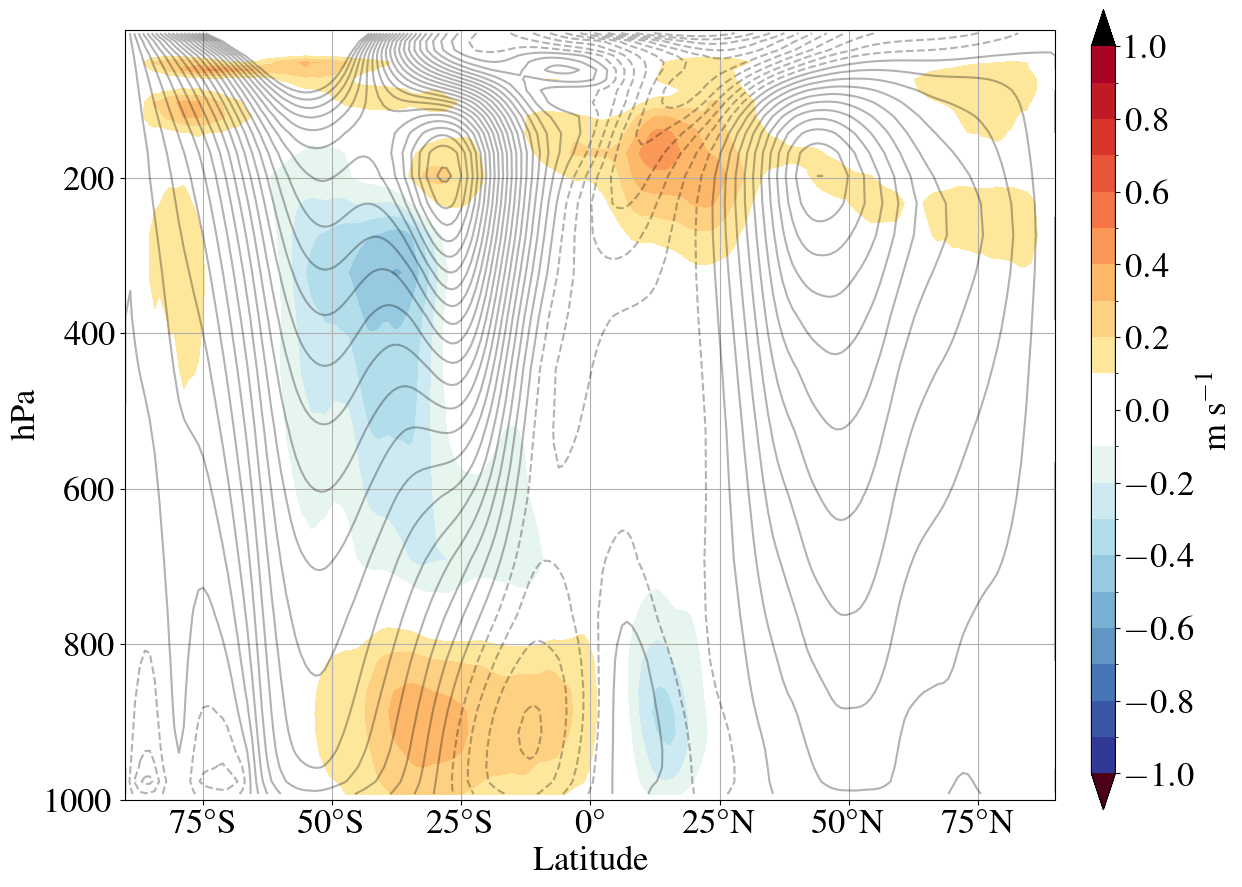

In [38]:
SEA = 'JJA'
# define the colormap
cmap = plt.cm.RdYlBu_r
# extract all colors from the Reds map
cmaplist = [cmap(i) for i in range(cmap.N)]
# make the first color entry to be whhite
cmaplist[0] = cmap(1)
# make the last color entry to be most extreme--
cmaplist[cmap.N-1] = cmap(0.99)

for ii in range(120,136):
    cmaplist[ii]=[1,1,1,1]

cmap.N
# create the new map
cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
clevels = np.arange(-1,1.1,.1)
contlevels = np.arange(-40,42,2)
norm = mpl.colors.BoundaryNorm(clevels, cmap.N)
cmap.set_under([0.3, 0.00, 0.1, 1.0])
cmap.set_over('k')
#plotting:
# plotterC=(D_obsh0.sel(season=SEA,lev=slice(10,1200)).U.squeeze().mean('lon'))
plotter= bbedo_chunked.sel(season=SEA,lev=slice(10,1200))['Nudge_U'].mean('lon')*21600
plotterC= bbedo_chunked.sel(season=SEA,lev=slice(10,1200))['U'].mean('lon')

lat = bbedo_chunked['lat']
plevv = bbedo_chunked['lev'].sel(lev=slice(10,1200))

fig, ax = plt.subplots(figsize=(12, 10))
ff=plt.contourf(lat,plevv,plotter,levels=clevels,cmap=cmap,norm=norm,extend='both')
plt.contour(lat,plevv,plotterC,levels=contlevels,colors='k',alpha=0.3)

plt.grid(True)
plt.ylim([10,1000])
#     row.invert_yaxis()
plt.xlabel('Latitude',fontsize=25)
plt.ylabel('hPa',fontsize=25)
lat_formatter = LatitudeFormatter(number_format='.0f')
plt.tick_params(labelsize=25) 
ax.invert_yaxis()
ax.xaxis.set_major_formatter(lat_formatter)
    
# create the colorbar
ax2 = fig.add_axes([0.93, 0.1, 0.02, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, extend='both', spacing='proportional', ticks=clevels, boundaries=clevels)
ax2.set_ylabel('m s$^{-1}$', size=25)
cb.ax.tick_params(labelsize=25)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()

### +++ saving
filepath = '/glade/work/wchapman/DA_ML/notebooks/Figures/Figure_output/'
plt.savefig(filepath +'/U_DA_Vertical_inc_structure_'+SEA+'.png', dpi=200,bbox_inches='tight')
### --- saving

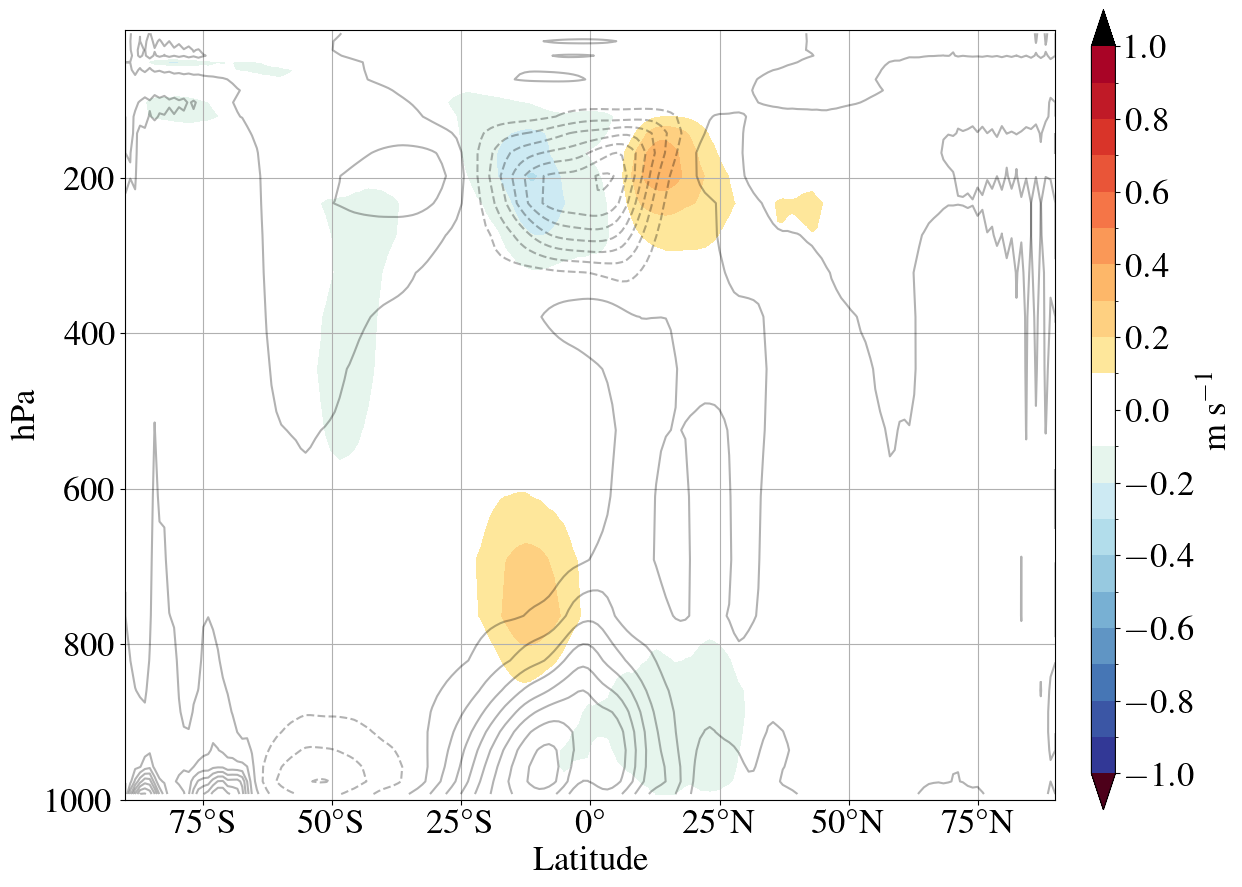

In [39]:
SEA = 'JJA'
# define the colormap
cmap = plt.cm.RdYlBu_r
# extract all colors from the Reds map
cmaplist = [cmap(i) for i in range(cmap.N)]
# make the first color entry to be whhite
cmaplist[0] = cmap(1)
# make the last color entry to be most extreme--
cmaplist[cmap.N-1] = cmap(0.99)

for ii in range(120,136):
    cmaplist[ii]=[1,1,1,1]

cmap.N
# create the new map
cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
clevels = np.arange(-1,1.1,.1)
contlevels = np.arange(-6,6.5,0.5)
norm = mpl.colors.BoundaryNorm(clevels, cmap.N)
cmap.set_under([0.3, 0.00, 0.1, 1.0])
cmap.set_over('k')
#plotting:
# plotterC=(D_obsh0.sel(season=SEA,lev=slice(10,1200)).U.squeeze().mean('lon'))
plotter= bbedo_chunked.sel(season=SEA,lev=slice(10,1200))['Nudge_V'].mean('lon')*21600 + bbedo_chunked.sel(season=SEA,lev=slice(10,1200))['Stochai_V'].mean('lon')*21600
plotterC= bbedo_chunked.sel(season=SEA,lev=slice(10,1200))['V'].mean('lon')


lat = bbedo_chunked['lat']
plevv = bbedo_chunked['lev'].sel(lev=slice(10,1200))

fig, ax = plt.subplots(figsize=(12, 10))
ff=plt.contourf(lat,plevv,plotter,levels=clevels,cmap=cmap,norm=norm,extend='both')
plt.contour(lat,plevv,plotterC,levels=contlevels,colors='k',alpha=0.3)

plt.grid(True)
plt.ylim([10,1000])
#     row.invert_yaxis()
plt.xlabel('Latitude',fontsize=25)
plt.ylabel('hPa',fontsize=25)
lat_formatter = LatitudeFormatter(number_format='.0f')
plt.tick_params(labelsize=25) 
ax.invert_yaxis()
ax.xaxis.set_major_formatter(lat_formatter)
    
# create the colorbar
ax2 = fig.add_axes([0.93, 0.1, 0.02, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, extend='both', spacing='proportional', ticks=clevels, boundaries=clevels)
ax2.set_ylabel('m s$^{-1}$', size=25)
cb.ax.tick_params(labelsize=25)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()


### +++ saving
filepath = '/glade/work/wchapman/DA_ML/notebooks/Figures/Figure_output/'
plt.savefig(filepath +'/V_DA_Vertical_inc_structure_'+SEA+'.png', dpi=200,bbox_inches='tight')
### --- saving